# Proyecto: Predicción de Alertas Térmicas mediante Aprendizaje Automático

Alumno: Mariano Buet

Se propone desarrollar un modelo de clasificación multiclase que prediga tres tipos de estados térmicos —riesgo de helada, clima de confort y riesgo de sobrecalor— a partir de variables meteorológicas.
El objetivo principal es anticipar condiciones extremas para apoyar la toma de decisiones preventivas en distintos ámbitos: agrícola (proteger cultivos), doméstico (evitar congelamiento de cañerías) e industrial (ajustar sistemas de ventilación o riego)

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
#Cardo el dataset directamente del Git
url = "https://github.com/MarianoBuet/Aprendizaje-Autom-tico/raw/main/Entregas_Parcial/datos/Estad%C3%ADsticas%20normales%20Datos%20abiertos%201991-2020%20-%20AJUSTADO.xlsx"

df = pd.read_excel(url,header=0)
df.head()

,Estacion,Mes,Dias de Lluvia,Humeda,Nubosidad,Precipitacion,Temp Media,Temp Max,Temp Min,Viento,Objetivo
0,AEROPARQUE AERO,Ene,6.7,67.0,3.1,117.5,24.5,28.4,20.8,16.8,NORMAL
1,AEROPARQUE AERO,Feb,6.0,69.8,3.2,112.3,23.7,27.3,20.2,15.8,NORMAL
2,AEROPARQUE AERO,Mar,5.9,71.3,3.1,111.8,22.0,25.5,18.8,14.9,NORMAL
3,AEROPARQUE AERO,Abr,6.6,73.6,3.5,108.3,18.5,22.0,15.3,13.9,NORMAL
4,AEROPARQUE AERO,May,5.0,76.4,4.0,83.3,15.2,18.4,12.3,12.9,NORMAL


# Analisis General del Set de Datos

Estructura General y tipos de variables

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Estacion        1171 non-null   object 
 1   Mes             1171 non-null   object 
 2   Dias de Lluvia  1061 non-null   float64
 3   Humeda          1110 non-null   float64
 4   Nubosidad       1166 non-null   float64
 5   Precipitacion   1061 non-null   float64
 6   Temp Media      1167 non-null   float64
 7   Temp Max        1158 non-null   float64
 8   Temp Min        1124 non-null   float64
 9   Viento          708 non-null    float64
 10  Objetivo        1171 non-null   object 
dtypes: float64(8), object(3)
memory usage: 100.8+ KB


Analisis de los valores nulos

In [82]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion            0
Mes                 0
Dias de Lluvia    110
Humeda             61
Nubosidad           5
Precipitacion     110
Temp Media          4
Temp Max           13
Temp Min           47
Viento            463
Objetivo            0
dtype: int64


Analisis Estadístico Rapido

In [83]:
display(df.describe(percentiles=[0.25,0.5,0.75]).T)

,count,mean,std,min,25%,50%,75%,max
Dias de Lluvia,1061.0,5.097455,2.536586,0.0,3.100,5.2,7.0,13.8
Humeda,1110.0,68.005405,11.027475,25.7,61.325,70.1,76.4,90.2
Nubosidad,1166.0,3.840137,0.888284,1.3,3.300,3.7,4.2,7.5
Precipitacion,1061.0,68.234873,51.674519,0.0,23.300,58.9,106.5,277.9
Temp Media,1167.0,14.834190,8.178787,-20.9,10.300,15.7,21.2,28.3
Temp Max,1158.0,21.223834,8.938676,-17.5,17.025,22.4,27.9,35.5
Temp Min,1124.0,9.102847,7.778743,-25.0,4.500,9.9,15.1,22.5
Viento,708.0,13.011582,5.554040,3.9,9.200,11.8,15.9,36.5


Analisis de las variables numéricas

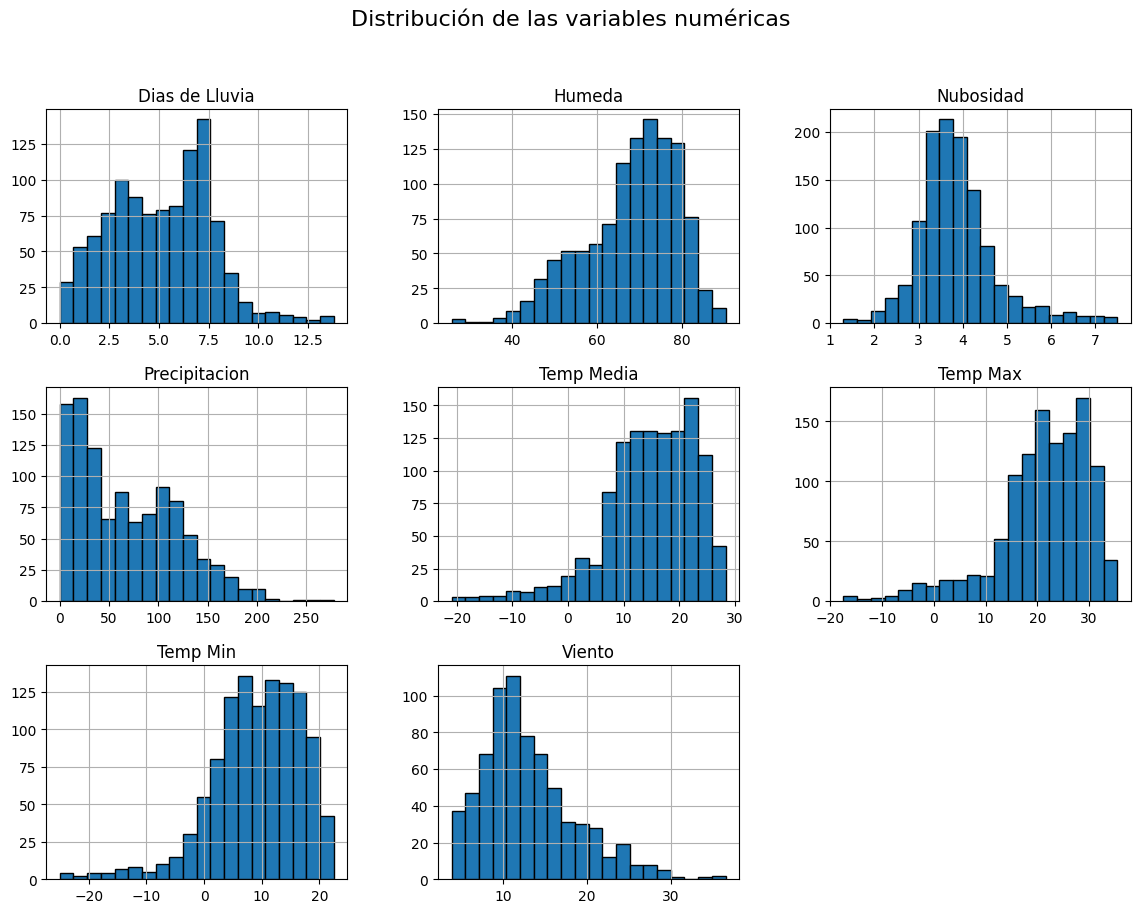

In [84]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns

df[variables_numericas].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Distribución de las variables numéricas", fontsize=16)
plt.show()

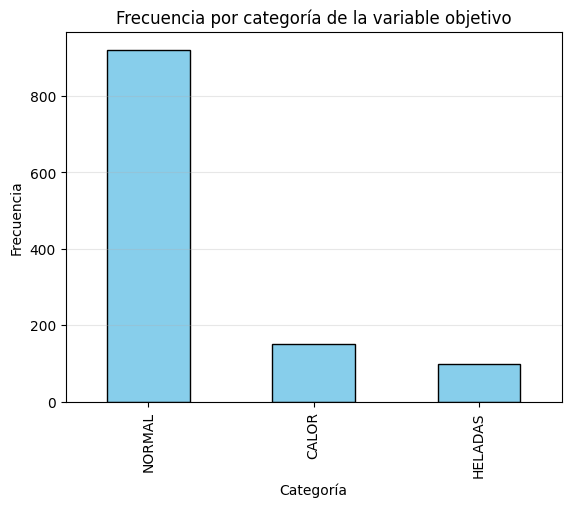

In [86]:
#Visualizar con un histograma la distribucion de la variable objetivo

df['Objetivo'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia por categoría de la variable objetivo')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.show()

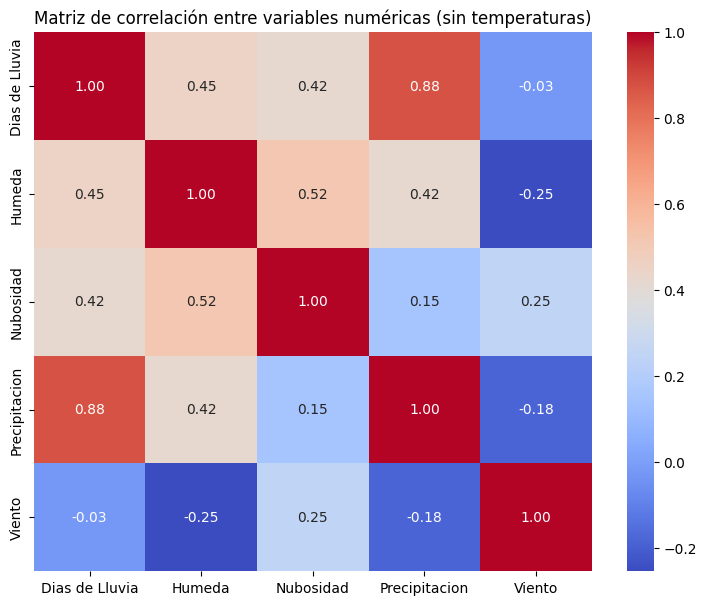

In [87]:
# Matriz de correlación (sin incluir temperaturas)
vars_corr = [c for c in df.select_dtypes(include=[np.number]).columns if "Temp" not in c]
plt.figure(figsize=(9,7))
sns.heatmap(df[vars_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas (sin temperaturas)")
plt.show()

Conclusiones del EDA

Las variables Humedad y Viento muestran patrones distintos según el tipo de alerta.

Los períodos de sobrecalor se asocian con mayor viento y menor humedad.

Los estados de helada se caracterizan por baja precipitación y alta nubosidad parcial.

Aunque no se usan temperaturas, las demás variables presentan señales predictivas útiles.

In [88]:
#  Muestro columnas con valores nulos
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0]

if faltantes.empty:
    print("No hay valores nulos en el dataset.")
else:
    print("Columnas con valores nulos:")
    display(faltantes)

#  Defino manualmente qué columnas usarán cada método


#Columnas que usaran la media
cols_media = ['Temp Media','Viento','Dias de Lluvia']

#Columnas que usaran la mediana
cols_mediana = ['Humeda','Precipitacion']

#Columnas que usaran Moda
cols_moda = ['Temp Min', 'Temp Max','Nubosidad']

#Aplicar Media
for col in cols_media:
    if col in df.columns:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)
        print(f"✅ Columna '{col}' completada con la MEDIA ({mean_value:.2f})")
    else:
        print(f"⚠️ La columna '{col}' no existe en el dataset")

# Aplicar Mediana
for col in cols_mediana:
    if col in df.columns:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"✅ Columna '{col}' completada con la MEDIANA ({median_value:.2f})")
    else:
        print(f"⚠️ La columna '{col}' no existe en el dataset")

# 5️⃣ Aplicar Opción 3 (moda)
for col in cols_moda:
    if col in df.columns:
        moda_series = df[col].mode(dropna=True)
        if len(moda_series) > 0:
            moda_val = moda_series.iloc[0]
            df[col].fillna(moda_val, inplace=True)
            print(f"✅ Columna '{col}' completada con la MODA ({moda_val})")
        else:
            print(f"⚠️ Columna '{col}' no tiene suficiente información para calcular la moda")
    else:
        print(f"⚠️ La columna '{col}' no existe en el dataset")

# 6️⃣ Verificación final
faltantes_final = df.isnull().sum()
if faltantes_final.sum() == 0:
    print("\n🎉 Todas las columnas quedaron completas, sin valores nulos.")
else:
    print("\n⚠️ Aún quedan valores nulos en las siguientes columnas:")
    print(faltantes_final[faltantes_final > 0])

Columnas con valores nulos:


,0
Dias de Lluvia,110
Humeda,61
Nubosidad,5
Precipitacion,110
Temp Media,4
Temp Max,13
Temp Min,47
Viento,463


✅ Columna 'Temp Media' completada con la MEDIA (14.83)
✅ Columna 'Viento' completada con la MEDIA (13.01)
✅ Columna 'Dias de Lluvia' completada con la MEDIA (5.10)
✅ Columna 'Humeda' completada con la MEDIANA (70.10)
✅ Columna 'Precipitacion' completada con la MEDIANA (58.90)
✅ Columna 'Temp Min' completada con la MODA (4.9)
✅ Columna 'Temp Max' completada con la MODA (27.9)
✅ Columna 'Nubosidad' completada con la MODA (3.7)

🎉 Todas las columnas quedaron completas, sin valores nulos.


/tmp/ipython-input-1940084857.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)
/tmp/ipython-input-1940084857.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [89]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion          0
Mes               0
Dias de Lluvia    0
Humeda            0
Nubosidad         0
Precipitacion     0
Temp Media        0
Temp Max          0
Temp Min          0
Viento            0
Objetivo          0
dtype: int64


# División del dataset en Entrenamiento y Test

🔹 Codificación automática (código → categoría):
  0 → CALOR
  1 → HELADAS
  2 → NORMAL

🔹 Mapeo en el DataFrame (muestra única):
   Objetivo  Objetivo_num
24    CALOR             0
41  HELADAS             1
0    NORMAL             2
✅ Columnas originales categóricas:
['Estacion', 'Mes']

✅ Columnas nuevas generadas por get_dummies:
['Estacion_AZUL AERO*', 'Estacion_BAHÃ\x8dA BLANCA AERO', 'Estacion_BARILOCHE AERO', 'Estacion_BASE BELGRANO II', 'Estacion_BASE CARLINI (EX JÃšBANY)', 'Estacion_BASE ESPERANZA', 'Estacion_BASE MARAMBIO', 'Estacion_BASE ORCADAS', 'Estacion_BASE SAN MARTÃ\x8dN', 'Estacion_BERNARDO DE IRIGOYEN AERO', 'Estacion_BOLÃ\x8dVAR AERO', 'Estacion_BUENOS AIRES OBSERVATORIO', 'Estacion_CATAMARCA AERO', 'Estacion_CERES AERO', 'Estacion_CHAMICAL AERO', 'Estacion_CHILECITO AERO', 'Estacion_COMODORO RIVADAVIA AERO', 'Estacion_CONCORDIA AERO', 'Estacion_CORONEL PRINGLES AERO*', 'Estacion_CORONEL SUÃ\x81REZ AERO', 'Estacion_CORRIENTES AERO', 'Estacion_CÃ“RDOBA AERO', 'Estacio

,Dias de Lluvia,Humeda,Nubosidad,Precipitacion,Viento,Estacion_AZUL AERO*,Estacion_BAHÃA BLANCA AERO,Estacion_BARILOCHE AERO,Estacion_BASE BELGRANO II,Estacion_BASE CARLINI (EX JÃšBANY),...,Mes_Dic,Mes_Ene,Mes_Feb,Mes_Jul,Mes_Jun,Mes_Mar,Mes_May,Mes_Nov,Mes_Oct,Mes_Sep
0,0.664028,-0.103757,-0.834644,1.018323,0.877845,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,0.373977,0.156911,-0.721784,0.912717,0.646127,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0.332541,0.296554,-0.834644,0.902563,0.437580,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0.622592,0.510674,-0.383204,0.831482,0.205862,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.040381,0.771341,0.181097,0.323763,-0.025856,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False



Total de columnas después de codificar: 113
🔹 Accuracy:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 0.872

📊 Matriz de Confusión:
[[ 28   0   2]
 [  0  20   0]
 [ 20   8 157]]

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       CALOR       0.58      0.93      0.72        30
     HELADAS       0.71      1.00      0.83        20
      NORMAL       0.99      0.85      0.91       185

    accuracy                           0.87       235
   macro avg       0.76      0.93      0.82       235
weighted avg       0.91      0.87      0.88       235



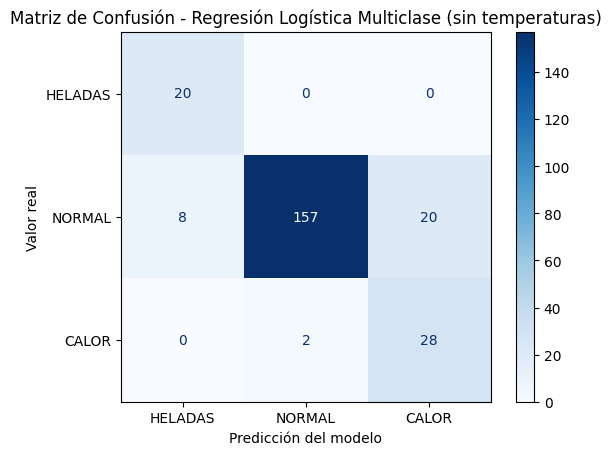

In [90]:
# ============================================
# Regresión Logística Multiclase - sin Temp Media/Max/Min
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Selección de variables (sin temperaturas)
cols_excluir = ["Temp Media", "Temp Max", "Temp Min", "Objetivo","Objetivo_num"]
X = df.drop(columns=[c for c in cols_excluir if c in df.columns])
y = df["Objetivo"]

# 🔎 Ver cómo están codificadas las categorías de la variable objetivo
y_cat = y.astype("category")

print("🔹 Codificación automática (código → categoría):")
for code, cat in enumerate(y_cat.cat.categories):
    print(f"  {code} → {cat}")

# Columna auxiliar (solo para inspección)
df["Objetivo_num"] = y_cat.cat.codes
print("\n🔹 Mapeo en el DataFrame (muestra única):")
print(df[["Objetivo", "Objetivo_num"]].drop_duplicates().sort_values("Objetivo_num"))

# 2️⃣ Codificación de categóricas y escalado de numéricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])



print("✅ Columnas originales categóricas:")
print(list(cat_cols))
print("\n✅ Columnas nuevas generadas por get_dummies:")
dummies_cols = [c for c in X.columns if any(cat in c for cat in cat_cols)]
print(dummies_cols[:30])  # muestra las primeras 30 si hay muchas

# Opcional: ver cómo quedó el DataFrame
print("\n📊 Primeras filas del dataset codificado:")
display(X.head())

# Cantidad de columnas totales
print(f"\nTotal de columnas después de codificar: {X.shape[1]}")



# 3️⃣ División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ Entrenamiento
log_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)
log_model.fit(X_train, y_train)

# 5️⃣ Predicciones y métricas
y_pred = log_model.predict(X_test)

print("🔹 Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n📊 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n📋 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))



labels = ["HELADAS", "NORMAL", "CALOR"]

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusión - Regresión Logística Multiclase (sin temperaturas)")
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.show()

🔹 Top 10 variables más influyentes en la predicción:


,Variable,Importancia (abs)
8,Estacion_BASE BELGRANO II,1.734384
37,Estacion_GOBERNADOR GREGORES AERO*,1.374605
24,Estacion_CORONEL SUÃREZ AERO,1.335117
51,Estacion_MAQUINCHAO,1.263232
104,Mes_Ene,1.221643
61,Estacion_ORÃN AERO*,1.092702
17,Estacion_CATAMARCA AERO,1.007794
105,Mes_Feb,1.002475
92,Estacion_TINOGASTA,1.000537
91,Estacion_TARTAGAL AERO,0.963896


/tmp/ipython-input-863925394.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Variable", x="Importancia (abs)", data=coef.head(10), palette="coolwarm")
/tmp/ipython-input-863925394.py:16: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


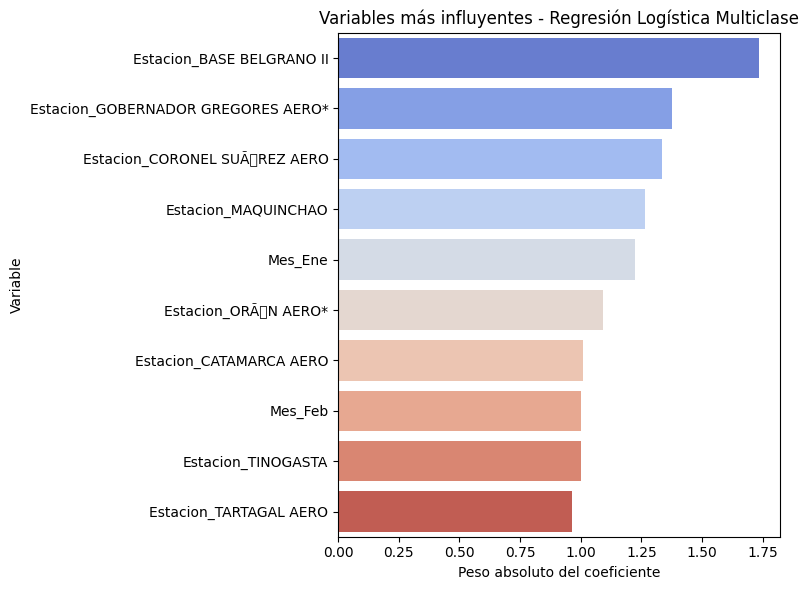

In [91]:
# 7️⃣ Importancia de las variables
import numpy as np

coef = pd.DataFrame({
    "Variable": X.columns,
    "Importancia (abs)": np.mean(np.abs(log_model.coef_), axis=0)
}).sort_values(by="Importancia (abs)", ascending=False)

print("🔹 Top 10 variables más influyentes en la predicción:")
display(coef.head(10))

plt.figure(figsize=(8,6))
sns.barplot(y="Variable", x="Importancia (abs)", data=coef.head(10), palette="coolwarm")
plt.title("Variables más influyentes - Regresión Logística Multiclase")
plt.xlabel("Peso absoluto del coeficiente")
plt.tight_layout()
plt.show()